<a href="https://colab.research.google.com/github/mz-zarei/CGAN_EB_Simulation/blob/main/CGAN_EB_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1) Import Libraies**


In [ ]:
%cd /content/drive/My Drive/GAN_regression/ganRegression/
%matplotlib inline

!pip install -r requirements.txt
!pip install -e 
!pip install xlsxwriter

import xlsxwriter
import importlib
import dataset, metrics, plotting, config, network
from models import cgan_model
import numpy as np
import random
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import kendalltau, pearsonr, spearmanr
import xlsxwriter
import os

import tensorflow as tf
from tensorflow import keras
from keras.layers import LeakyReLU
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats
from tqdm import tqdm
from keras.layers import Activation
from keras import activations

pd.options.display.max_columns = 200
pd.options.display.max_rows = 200



import os
from tensorflow.compat.v1 import set_random_seed
# Set random seed
random_seed = 10


site_type = 'simulation'

dataset_config = config.DatasetConfig(scenario=site_type)

assert(dataset_config.scenario == "comp-activ"
      or dataset_config.scenario == "simulation"
      or dataset_config.scenario == "midblock_wau2"
      or dataset_config.scenario == "midblock_wa")
fig_dir = f"/content/drive/My Drive/GAN_regression/ganRegression/figures/{dataset_config.scenario}"


try:
    os.mkdir(fig_dir)
    print(f"Directory {fig_dir} created ") 
except FileExistsError:
    print(f"Directory {fig_dir} already exists replacing files in this notebook")



def FI(results, i):

    nb_test = 1-results[(results['true_rank'] > 1- i) & (results['nb_rank'] > 1- i)].count()[0]/results[(results['true_rank'] > 1- i)].count()[0]
    gan_test = 1-results[(results['true_rank'] > 1- i) & (results['gan_rank'] > 1- i)].count()[0]/results[(results['true_rank'] > 1- i)].count()[0]
    
    if nb_test==0:
        out = round((nb_test - gan_test)/1*100,3)
    else:
        out = round((nb_test - gan_test)/nb_test*100,3)
    return nb_test, gan_test, out
def MAE_h(results,i):
    nb_test = abs((results[(results['true_rank'] > 1- i)]['y_true'] - results[(results['true_rank'] > 1- i)]['EB_nb'])).mean()
    gan_test = abs((results[(results['true_rank'] > 1- i)]['y_true'] - results[(results['true_rank'] > 1- i)]['EB_gan'])).mean()

    return nb_test, gan_test, round(-(gan_test - nb_test)/nb_test*100,3)
def MAPE_h(results,i):
    nb_test = abs((results[(results['true_rank'] > 1- i)]['y_true'] - results[(results['true_rank'] > 1- i)]['EB_nb'])/results[(results['true_rank'] > 1- i)]['y_true']).mean()
    gan_test = abs((results[(results['true_rank'] > 1- i)]['y_true'] - results[(results['true_rank'] > 1- i)]['EB_gan'])/results[(results['true_rank'] > 1- i)]['y_true']).mean()

    return nb_test, gan_test, round(-(gan_test - nb_test)/nb_test*100,3)
def PMD(results, i):
    nb_test = (results[results['true_rank'] > 1-i]['y_true'].mean() - results[results['nb_rank'] > 1-i]['y_true'].mean())/results[results['true_rank'] > 1-i]['y_true'].mean()
    gan_test = (results[results['true_rank'] > 1-i]['y_true'].mean() - results[results['gan_rank'] > 1-i]['y_true'].mean())/results[results['true_rank'] > 1-i]['y_true'].mean()
    return nb_test, gan_test, round((nb_test - gan_test)/nb_test*100,3)



import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

def fit_NB(data, x_data, y_data):
    ########    Calculating alpha
    result = data.copy()
    result.reset_index(inplace=True)
    X = sm.add_constant(x_data)
    y =  y_data

    poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()

    result['lambda'] = poisson_model.mu

    result['AUX_OLS_DEP'] = result.apply(lambda x: ((x['y_train'] - x['lambda'])**2 - x['lambda']) / x['lambda'], axis=1)


    aux_olsr_results = sm.OLS(result['AUX_OLS_DEP'], result['lambda']).fit()
    alpha = aux_olsr_results.params
    alpha_se = aux_olsr_results.bse
    # print("Disperssion: ", round(alpha[0],3), " | SE: ", round(aux_olsr_results.bse[0],3))
    result['alpha'] = alpha[0]

    NB_model = sm.GLM(y, X,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()
    y_pred_NB = pd.DataFrame(NB_model.predict(X))
    return NB_model, alpha[0], y_pred_NB

def MAPE(actual, predicted):
    res = np.empty(len(actual))
    for j in range(len(actual)):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return np.mean(np.abs(res))

### Stepwise feature selection functions
def forward_regression(data, X, y, threshold_in, verbose=False):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model, _, _ = fit_NB(data, pd.DataFrame(X[included+[new_column]]), y)
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        if not changed:
            break

    return included


def backward_regression(data, X, y, threshold_out, verbose=False):
    included=list(X.columns)
    while True:
        changed=False
        model, _, _ = fit_NB(data, pd.DataFrame(X[included]), y)
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included


def predict_by_GAN(GAN, xtest):
    noise = np.random.normal(0, 1, (xtest.shape[0], z_input_size))
    ypred = GAN.predict([noise, xtest])
    return np.array(ypred)
def sample(GAN, xtest, n_samples):
    y_samples_gan = predict_by_GAN(GAN, xtest)
    for i in range(n_samples - 1):
        ypred_gan = predict_by_GAN(GAN, xtest)
        y_samples_gan = np.hstack([y_samples_gan, ypred_gan])
    median = []
    mean = []
    mode = []
    Var = []
    for j in range(y_samples_gan.shape[0]):
        median.append(np.median(y_samples_gan[j, :]))
        mean.append(np.mean(y_samples_gan[j, :]))
        mode.append(stats.mode(y_samples_gan[j, :])[0])
        Var.append(np.var(y_samples_gan[j, :]))
    return np.array(median).reshape(1,-1)[0], np.array(Var).reshape(1,-1)[0] , np.array(mean).reshape(1,-1)[0], y_samples_gan


/content/drive/My Drive/GAN_regression/ganRegression
     |████████████████████████████████| 959 kB 8.3 MB/s 
     |████████████████████████████████| 71 kB 10.8 MB/s 
  Created wheel for GPy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2565099 sha256=8bfeac0f888559812ba5abccd9652595c62df0b82fd5d577212eb89e62448403
  Stored in directory: /root/.cache/pip/wheels/f7/18/28/dd1ce0192a81b71a3b086fd952511d088b21e8359ea496860a
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102565 sha256=2d68efabf9ecaf6c7006b7877a64c42453e78b0850238ce5eed5c32fdb6c03bf
  Stored in directory: /root/.cache/pip/wheels/c8/95/f5/ce28482da28162e6028c4b3a32c41d147395825b3cd62bc810
Successfully built GPy paramz

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 in

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Generating Simulated Crash counts with WA data**

4.249670999999993
1.823
Scenario: 1000 0.5 0.5


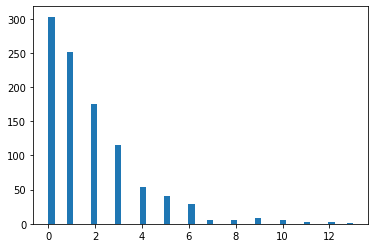

In [ ]:
error_mean = 1

data_size = [1000]
error_variance = [0.5]
constant = [0.5]

s_list = [[i, j, k] for i in data_size 
                 for j in error_variance
                 for k in constant]


for s in s_list:
    data_size = s[0]
    error_variance = s[1]
    constant = s[2]

    y_train = []
    x_train = []
    y_true = []


    for i in range(data_size):
        b_vector = np.array([0.05, -0.05, 1, -1])  
        X1 = np.random.uniform(0,1,1)[0]
        X2 = np.random.uniform(0,1,1)[0]
        X3 = np.random.uniform(0,1,1)[0]
        X4 = np.random.uniform(0,1,1)[0]

        X = [X1, X2, X3, X4]
        # X_b = [X1, X2, X3, X4]
        X_b = [X1**0.5, X2**0.5, X3**2, X4*X1]  

        scale = error_variance/error_mean
        shape = error_mean/scale
        error_term = np.random.gamma(shape = shape, scale=scale)     

        ro = np.exp(np.dot(b_vector,X_b) + constant)
        lambda_true = ro * error_term
        y_true.append(lambda_true)
        y_train.append(np.random.poisson(lam = lambda_true))
        x_train.append(X)


    simulated_data = pd.DataFrame(x_train, columns=['x1','x2','x3','x4'])
    simulated_data['y_train'] = y_train
    simulated_data['y_true'] = y_true

    y_train = simulated_data['y_train']
    y_true = simulated_data['y_true']
    x_train = simulated_data[['x1','x2','x3','x4']]

    # simulated_data.to_excel('/content/drive/MyDrive/GAN_regression/ganRegression/SimulatedData/'+'F8-5_'+str(data_size)+'_'+str(error_variance)+'_'+str(constant)+'.xlsx')

    count, bins, ignored = plt.hist(y_train, 50, density=False)
    print(np.var(y_train))
    print(np.mean(y_train))
    print('Scenario:', data_size, error_variance, constant)
    plt.show()
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x_train)


# **Modeling with NB model**

6.686755999999945
1.662


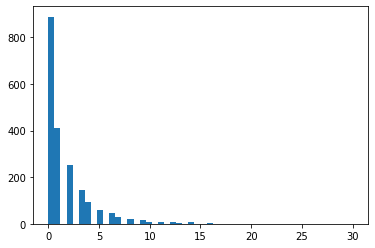

In [ ]:
scenario = 'E3'
Replication = 1

scenario_dict = {'E1':[2000,0.5,0.5],'E2':[2000,0.5,2.5],'E3':[2000,1.5,0.5],'E4':[2000,1.5,2.5],
                 'E5':[1000,0.5,0.5],'E6':[1000,0.5,2.5],'E7':[1000,1.5,0.5],'E8':[1000,1.5,2.5],
                 'E9':[500,0.5,0.5],'E10':[500,0.5,2.5],'E11':[500,1.5,0.5],'E12':[500,1.5,2.5],
                 'F5':[1000,0.5,0.5],'F6':[1000,0.5,2.5],'F7':[1000,1.5,0.5],'F8':[1000,1.5,2.5],
                 'C5':[1000,0.5,0.5],'C6':[1000,0.5,2.5],'C7':[1000,1.5,0.5],'C8':[1000,1.5,2.5],}


data_size = scenario_dict[scenario][0]
error_variance = scenario_dict[scenario][1]
constant = scenario_dict[scenario][2]

path = '/content/drive/MyDrive/GAN_regression/ganRegression/SimulatedData/' + 'R'+str(Replication)+'_'+str(data_size)+'_'+str(error_variance)+'_'+str(constant)+'.xlsx'
# path = '/content/drive/MyDrive/GAN_regression/ganRegression/SimulatedData/' + str(scenario)+'-'+str(Replication)+'_'+str(data_size)+'_'+str(error_variance)+'_'+str(constant)+'.xlsx'


simulated_data = pd.read_excel(path,index_col=0)
y_train = simulated_data['y_train']
y_true = simulated_data['y_true']
x_train = simulated_data[['x1','x2','x3','x4']]
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_train)
y = y_train.values
count, bins, ignored = plt.hist(y_train, 50, density=False)
print(np.var(y_train))
print(np.mean(y_train))
plt.show()


In [ ]:
# Find significant features
significant_features = backward_regression(simulated_data, x_train, y_train, 0.05, verbose=False)

NB_model, alpha, y_pred_NB  = fit_NB(simulated_data, x_train[significant_features], y_train)

print("MAPE: ", round(MAPE(y_train, y_pred_NB.values.transpose()[0]),3),
      "| MAE: ", round(mean_absolute_error(y_train, y_pred_NB.values.transpose()[0]),3),
      "| R2 score: ", round(r2_score(y_train, y_pred_NB),3),
      '| Alpha: ', round(alpha,3))

print(NB_model.summary2())

# VIF calculation
vifs = pd.Series(np.linalg.inv(x_train[significant_features].corr().to_numpy()).diagonal(), 
            index=x_train[significant_features].columns, 
            name='VIF')
print("=====VIFs=====")
print(vifs)



MAPE:  0.723 | MAE:  1.693 | R2 score:  0.055 | Alpha:  1.484
               Results: Generalized linear model
Model:              GLM              AIC:            6846.6225  
Link Function:      log              BIC:            -13209.2580
Dependent Variable: y_train          Log-Likelihood: -3420.3    
Date:               2021-10-27 21:58 LL-Null:        -3484.0    
No. Observations:   2000             Deviance:       1969.7     
Df Model:           2                Pearson chi2:   1.93e+03   
Df Residuals:       1997             Scale:          1.0000     
Method:             IRLS                                        
------------------------------------------------------------------
          Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
------------------------------------------------------------------
const     0.4338     0.0864    5.0211   0.0000    0.2645    0.6032
x3        0.9021     0.1144    7.8855   0.0000    0.6779    1.1263
x4       -0.9028     0.1137   -7.9


# **Training CGAN model**

In [ ]:
# Train the CGAN model
import dataset, metrics, plotting, config, network
from models import cgan_model
from keras import callbacks 
importlib.reload(network)
importlib.reload(dataset)
importlib.reload(metrics)
importlib.reload(plotting)
importlib.reload(config)
importlib.reload(cgan_model)


exp_config = config.Config(
        model=config.ModelConfig(activation="elu", lr_gen=0.001, lr_disc=0.001, dec_gen=0.001, dec_disc=0, 
                                 optim_gen="Adam", optim_disc="Adam", z_input_size=1, random_seed=random_seed),
        training=config.TrainingConfig(n_epochs=501, batch_size=100, n_samples=100),
        dataset=dataset_config,
        run=config.RunConfig(save_fig=1))


cgan = cgan_model.CGAN(exp_config)

d_loss_err, d_loss_true, d_loss_fake, g_loss_err, g_pred, g_true, RealAcc, FakeAcc = cgan.train(x_scaled, y_train.values, x_scaled, y_train.values,
                                                                              epochs=exp_config.training.n_epochs,
                                                                              batch_size=exp_config.training.batch_size)
 
plotting.plots(d_loss_err, d_loss_true, d_loss_fake, g_loss_err, g_pred, g_true, fig_dir, exp_config.run.save_fig)


In [ ]:
plt.plot(RealAcc)
plt.plot(FakeAcc)
plt.show()
plotting.plots(d_loss_err, d_loss_true, d_loss_fake, g_loss_err, g_pred, g_true, fig_dir, exp_config.run.save_fig)

# **EB Estimates and FI PMD tests**

In [ ]:
scenario = 'E3'
Replication = 3

scenario_dict = {'E1':[2000,0.5,0.5],'E2':[2000,0.5,2.5],'E3':[2000,1.5,0.5],'E4':[2000,1.5,2.5],
                 'E5':[1000,0.5,0.5],'E6':[1000,0.5,2.5],'E7':[1000,1.5,0.5],'E8':[1000,1.5,2.5],
                 'E9':[500,0.5,0.5],'E10':[500,0.5,2.5],'E11':[500,1.5,0.5],'E12':[500,1.5,2.5],
                 'F5':[1000,0.5,0.5],'F6':[1000,0.5,2.5],'F7':[1000,1.5,0.5],'F8':[1000,1.5,2.5],
                 'C5':[1000,0.5,0.5],'C6':[1000,0.5,2.5],'C7':[1000,1.5,0.5],'C8':[1000,1.5,2.5],}


data_size = scenario_dict[scenario][0]
error_variance = scenario_dict[scenario][1]
constant = scenario_dict[scenario][2]

path = '/content/drive/MyDrive/GAN_regression/ganRegression/SimulatedData/' + 'R'+str(Replication)+'_'+str(data_size)+'_'+str(error_variance)+'_'+str(constant)+'.xlsx'
# path = '/content/drive/MyDrive/GAN_regression/ganRegression/SimulatedData/' + str(scenario)+'-'+str(Replication)+'_'+str(data_size)+'_'+str(error_variance)+'_'+str(constant)+'.xlsx'


simulated_data = pd.read_excel(path,index_col=0)
y_train = simulated_data['y_train']
y_true = simulated_data['y_true']
x_train = simulated_data[['x1','x2','x3','x4']]
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_train)


scenario = 'E3'
Replication = 1




sample_size = 200
GANmodel = '/content/drive/MyDrive/GAN_regression/ganRegression/trained_models/genSim_'+scenario+'_'+str(Replication)+'.h5' 
# GANmodel = '/content/drive/MyDrive/GAN_regression/ganRegression/trained_models/gen_e475.h5' 
print(GANmodel)

GAN = keras.models.load_model(GANmodel , custom_objects={'LeakyReLU': LeakyReLU(), 'Activation': Activation(activations.exponential), 'layers':keras.layers})
y_pred_gan_median,  y_pred_gan_var, y_pred_gan_mean, predictions = sample(GAN, x_scaled, sample_size)
y_pred_NB = NB_model.predict(sm.add_constant(x_train[significant_features]))
z_input_size = 1



for i in [1]:
    print("CGAN MAPE: ", round(MAPE(y_train, y_pred_gan_mean),3),
        "| CGAN MAE: ", round(mean_absolute_error(y_train, y_pred_gan_mean),3),
        "| R2 score: ", round(r2_score(y_train, y_pred_gan_mean),3))

    print("NB MAPE: ", round(MAPE(y_train, y_pred_NB),3),
        "| NB MAE: ", round(mean_absolute_error(y_train, y_pred_NB),3),
        "| R2 score: ", round(r2_score(y_train, y_pred_NB),3))

    results = simulated_data.copy()

    results['y_pred_nb'] = y_pred_NB
    results['y_pred_gan_mean'] = y_pred_gan_mean
    results['y_pred_gan_var'] = y_pred_gan_var
    results['y_pred_gan_med'] = y_pred_gan_median
    results['alpha'] = alpha

    # results.loc[results['y_pred_gan_mean'] < 0, 'y_pred_gan_mean'] = 0

    results['w_nb'] = 1/(1+results['alpha']*results['y_pred_nb'])
    results['EB_nb'] = results['w_nb']*results['y_pred_nb'] + (1-results['w_nb'])*results['y_train']

    results['w_gan'] = results['y_pred_gan_mean']/(results['y_pred_gan_var']+results['y_pred_gan_mean'])
    results.loc[results['w_gan'] > 1, 'w_gan'] = 1
    results.loc[results['y_pred_gan_var'] == 0, 'w_gan'] = 1

    results['EB_gan'] = results['w_gan']*results['y_pred_gan_mean'] + (1-results['w_gan'])*results['y_train']


    results['true_rank'] =  results['y_true'].rank(pct=True)
    results['nb_rank'] =  results['EB_nb'].rank(pct=True)
    results['gan_rank'] =  results['EB_gan'].rank(pct=True)

    results['nb_mae'] =  abs(results['EB_nb'] - results['y_true'])
    results['gan_mae'] =  abs(results['EB_gan'] - results['y_true'])


    results.to_excel('/content/result.xlsx')
    mae_gan = round(mean_absolute_error(results['y_true'], results['EB_gan']),3)
    mae_nb =  round(mean_absolute_error(results['y_true'], results['EB_nb']),3)

    mape_gan = round(MAPE(results['y_true'], results['EB_gan']),3)
    mape_nb =  round(MAPE(results['y_true'], results['EB_nb']),3)

    mse_gan = round(mean_squared_error(results['y_true'], results['EB_gan']),3)
    mse_nb = round(mean_squared_error(results['y_true'], results['EB_nb']),3)

    r2_gan = round(r2_score(results['y_true'], results['EB_gan']),3)
    r2_nb = round(r2_score(results['y_true'], results['EB_nb']),3)

    # print(GANmodel)
    print('MAPE GAN-EB: ', mape_gan, 'MAE : ', mae_gan, ' | R2 : ', r2_gan)
    print('MAPE NB-EB: ', mape_nb, 'MAE : ', mae_nb, '| R2 : ', r2_nb)


    # print('\n', 
    #     round(MAPE(y_train, y_pred_gan_mean),3), '\n',
    #     round(mean_absolute_error(y_train, y_pred_gan_mean),3), '\n',
    #     round(r2_score(y_train, y_pred_gan_mean),3), '\n',
    #     round(MAPE(y_train, y_pred_NB),3), '\n',
    #     round(mean_absolute_error(y_train, y_pred_NB),3),'\n',
    #     round(r2_score(y_train, y_pred_NB),3))


    # print('\n', 
    #     mape_gan, '\n',
    #     mae_gan, '\n',
    #     r2_gan, '\n',
    #     mape_nb, '\n',
    #     mae_nb, '\n',
    #     r2_nb)

# results.to_excel('res.xlsx')
hotspot_percentage =  [0.03, 0.045, 0.08, 0.105] #np.arange(0.01,0.11,0.01) #

res = []
for i in hotspot_percentage:
    FI_nb, FI_gan, FI_change = FI(results,i)
    PMD_nb, PMD_gan, PMD_change = PMD(results,i)
    MAPE_nb, MAPE_gan, MAPE_change = MAPE_h(results,i)


    res.append([FI_nb, FI_gan, FI_change, PMD_nb, PMD_gan, PMD_change, MAPE_nb, MAPE_gan, MAPE_change])

res = pd.DataFrame(res, columns=['FI-NB', 'FI-CGAN', 'FI-Change','PMD-NB', 'PMD-CGAN', 'PMD-change', 'MAPE-NB', 'MAPE-CGAN', 'MAPE-Change'])
res['HS']=hotspot_percentage

# res.to_excel('/content/resPIFI_'+scenario+'.xlsx')

res

In [ ]:
hotspot_percentage =  [0.025, 0.05, 0.075, 0.10]
all_res = pd.DataFrame(columns=['FI-NB', 'FI-CGAN', 'FI-Change','PMD-NB', 'PMD-CGAN', 'PMD-change', 'MAPE-NB', 'MAPE-CGAN', 'MAPE-Change', 'case'])

for  scenario in ['F8']:

    for Replication in range(1,6):


        data_size = scenario_dict[scenario][0]
        error_variance = scenario_dict[scenario][1]
        constant = scenario_dict[scenario][2]

        # path = '/content/drive/MyDrive/GAN_regression/ganRegression/SimulatedData/' + 'R'+str(Replication)+'_'+str(data_size)+'_'+str(error_variance)+'_'+str(constant)+'.xlsx'
        path = '/content/drive/MyDrive/GAN_regression/ganRegression/SimulatedData/' + str(scenario)+'-'+str(Replication)+'_'+str(data_size)+'_'+str(error_variance)+'_'+str(constant)+'.xlsx'


        simulated_data = pd.read_excel(path,index_col=0)
        y_train = simulated_data['y_train']
        y_true = simulated_data['y_true']
        x_train = simulated_data[['x1','x2','x3','x4']]
        scaler = StandardScaler()
        x_scaled = scaler.fit_transform(x_train)


        significant_features = backward_regression(simulated_data, x_train, y_train, 0.05, verbose=False)
        NB_model, alpha, y_pred_NB  = fit_NB(simulated_data, x_train[significant_features], y_train)


        sample_size = 200
        GANmodel = '/content/drive/MyDrive/GAN_regression/ganRegression/trained_models/genSim_'+scenario+'_'+str(Replication)+'.h5' 
        GAN = keras.models.load_model(GANmodel , custom_objects={'LeakyReLU': LeakyReLU(), 'Activation': Activation(activations.exponential), 'layers':keras.layers})
        

        for Replication1 in range(1,6):
            path = '/content/drive/MyDrive/GAN_regression/ganRegression/SimulatedData/' + 'R'+str(Replication1)+'_'+str(data_size)+'_'+str(error_variance)+'_'+str(constant)+'.xlsx'


            simulated_data = pd.read_excel(path,index_col=0)
            y_train = simulated_data['y_train']
            y_true = simulated_data['y_true']
            x_train = simulated_data[['x1','x2','x3','x4']]
            scaler = StandardScaler()
            x_scaled = scaler.fit_transform(x_train)
                
            y_pred_gan_median,  y_pred_gan_var, y_pred_gan_mean, predictions = sample(GAN, x_scaled, sample_size)
            y_pred_NB = NB_model.predict(sm.add_constant(x_train[significant_features]))
            z_input_size = 1



            

            results = simulated_data.copy()

            results['y_pred_nb'] = y_pred_NB
            results['y_pred_gan_mean'] = y_pred_gan_mean
            results['y_pred_gan_var'] = y_pred_gan_var
            results['y_pred_gan_med'] = y_pred_gan_median
            results['alpha'] = alpha

            # results.loc[results['y_pred_gan_mean'] < 0, 'y_pred_gan_mean'] = 0

            results['w_nb'] = 1/(1+results['alpha']*results['y_pred_nb'])
            results['EB_nb'] = results['w_nb']*results['y_pred_nb'] + (1-results['w_nb'])*results['y_train']

            results['w_gan'] = results['y_pred_gan_mean']/(results['y_pred_gan_var']+results['y_pred_gan_mean'])
            results.loc[results['w_gan'] > 1, 'w_gan'] = 1
            results.loc[results['y_pred_gan_var'] == 0, 'w_gan'] = 1

            results['EB_gan'] = results['w_gan']*results['y_pred_gan_mean'] + (1-results['w_gan'])*results['y_train']


            results['true_rank'] =  results['y_true'].rank(pct=True)
            results['nb_rank'] =  results['EB_nb'].rank(pct=True)
            results['gan_rank'] =  results['EB_gan'].rank(pct=True)

            results['nb_mae'] =  abs(results['EB_nb'] - results['y_true'])
            results['gan_mae'] =  abs(results['EB_gan'] - results['y_true'])


            res = []
            for i in hotspot_percentage:
                FI_nb, FI_gan, FI_change = FI(results,i)
                PMD_nb, PMD_gan, PMD_change = PMD(results,i)
                MAPE_nb, MAPE_gan, MAPE_change = MAPE_h(results,i)


                res.append([FI_nb, FI_gan, FI_change, PMD_nb, PMD_gan, PMD_change, MAPE_nb, MAPE_gan, MAPE_change, scenario])

            res = pd.DataFrame(res, columns=['FI-NB', 'FI-CGAN', 'FI-Change','PMD-NB', 'PMD-CGAN', 'PMD-change', 'MAPE-NB', 'MAPE-CGAN', 'MAPE-Change', 'case'])
            print('Case ', scenario, Replication1)
            all_res = pd.concat([all_res, res])
            



# **Charts and Figures**

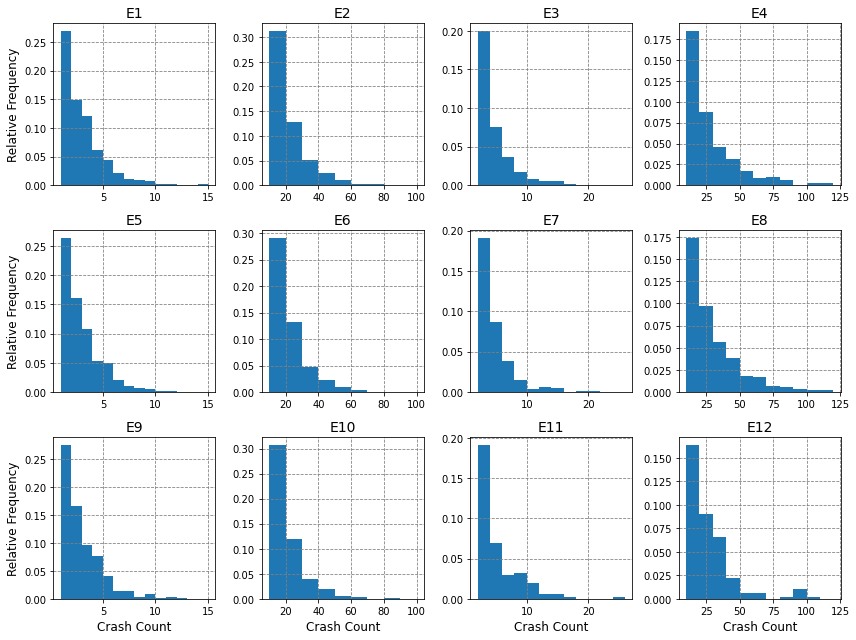

In [ ]:
## Distributions

scenario_dict = {'E1':[2000,0.5,0.5],'E2':[2000,0.5,2.5],'E3':[2000,1.5,0.5],'E4':[2000,1.5,2.5],
                 'E5':[1000,0.5,0.5],'E6':[1000,0.5,2.5],'E7':[1000,1.5,0.5],'E8':[1000,1.5,2.5],
                 'E9':[500,0.5,0.5],'E10':[500,0.5,2.5],'E11':[500,1.5,0.5],'E12':[500,1.5,2.5],}

e_list = ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12']
bins = {'E1':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],'E5':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],'E9':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
        'E2':[10,20,30,40,50,60,70,80,90,100],'E6':[10,20,30,40,50,60,70,80,90,100],'E10':[10,20,30,40,50,60,70,80,90,100],
        'E3':[2,4,6,8,10,12,14,16,18,20,22,24,26],'E7':[2,4,6,8,10,12,14,16,18,20,22,24,26],'E11':[2,4,6,8,10,12,14,16,18,20,22,24,26],
        'E4':[10,20,30,40,50,60,70,80,90,100,110,120],'E8':[10,20,30,40,50,60,70,80,90,100,110,120],'E12':[10,20,30,40,50,60,70,80,90,100,110,120]}

f,a = plt.subplots(3,4,figsize=(12,9))
a = a.ravel()

for scenario, idx, ax in zip(e_list,range(12),a):
    data_size = scenario_dict[scenario][0]
    error_variance = scenario_dict[scenario][1]
    constant = scenario_dict[scenario][2]
    path = '/content/drive/MyDrive/GAN_regression/ganRegression/SimulatedData/' + 'R1_'+str(data_size)+'_'+str(error_variance)+'_'+str(constant)+'.xlsx'


    simulated_data = pd.read_excel(path,index_col=0)
    y_train = simulated_data['y_train']
    y = y_train.values
    
    a[idx].hist(y_train,  bins = bins[scenario], weights=np.zeros_like(y_train) + 1. / len(y_train))
    a[idx].set_title(scenario, fontsize=14)
    if scenario in ['E9','E10','E11','E12']:
        a[idx].set_xlabel('Crash Count', fontsize=12)
    if scenario in ['E1','E5','E9']:
        a[idx].set_ylabel('Relative Frequency', fontsize=12)

    
    a[idx].grid(color='gray', linestyle='dashed')
    plt.tight_layout()
f.savefig('/content/Dists.pdf')

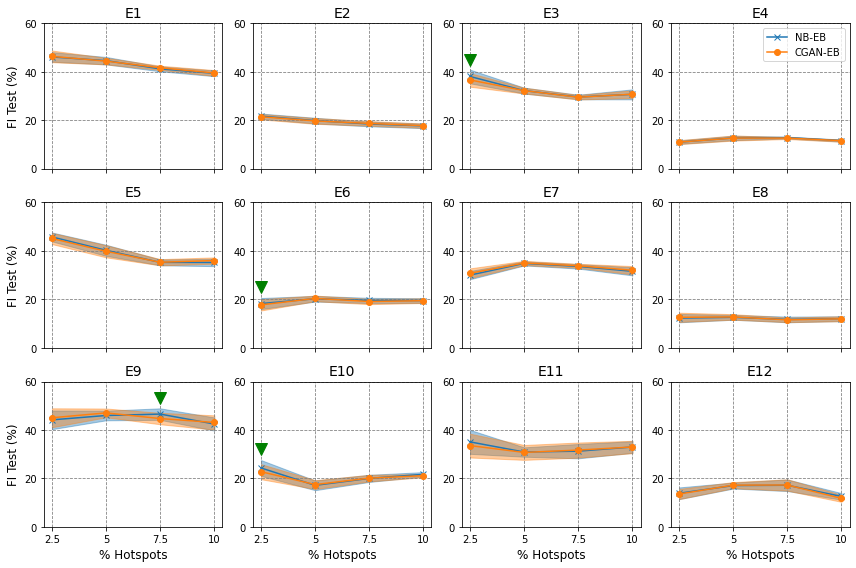

In [ ]:
## FI plots

data = pd.read_excel('/content/Results.xlsx', sheet_name='Plots')
data['HS'] = data['HS']/10
f,a = plt.subplots(3,4,figsize=(12,8), sharex=True)
a = a.ravel()
e_list = ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12']

xy = {'E3':([0.25],[0.45]),
      'E6':([0.25],[0.25]),
      'E9':([0.75],[0.53]),
      'E10':([0.25],[0.32]),
      }

def draw_circle(x_s,y_s,r, ax):
    for x,y in zip(x_s,y_s):
        cir = plt.Circle((x, y), r, color='g',fill=False, clip_on = False)
        ax.add_patch(cir)


for scenario, idx, ax in zip(e_list,range(12),a):
    data_e = data[data['Ex']==scenario].copy()
    a[idx].plot(data_e['HS'], data_e['TI NB-EB AVG'], label = 'NB-EB', marker='x')
    a[idx].plot(data_e['HS'], data_e['TI CGAN-EB AVG'],  label = 'CGAN-EB', marker='o')
    a[idx].set_title(scenario, fontsize=14)

    if scenario in ['E9','E10','E11','E12']:
        a[idx].set_xlabel('% Hotspots', fontsize=12)
    if scenario in ['E1','E5','E9']:
        a[idx].set_ylabel('FI Test (%)', fontsize=12)

    
    if scenario == 'E4':
        a[idx].legend(loc='upper right')
    a[idx].set_xticks([0.25,0.5,0.75,1])
    a[idx].set_xticklabels([2.5,5,7.5,10])

    a[idx].set_yticks([0,0.2,0.4,0.6])
    a[idx].set_yticklabels([0,0.2,0.4,0.6])

    a[idx].grid(color='gray', linestyle='dashed')

    a[idx].fill_between(data_e['HS'], data_e['TI NB-EB AVG'] - data_e['TI_nb_range'], data_e['TI NB-EB AVG'] + data_e['TI_nb_range'],
                 color='C0', alpha=0.4)
    a[idx].fill_between(data_e['HS'], data_e['TI CGAN-EB AVG'] - data_e['TI_gan_range'], data_e['TI CGAN-EB AVG'] + data_e['TI_gan_range'],
                 color='C1', alpha=0.4)


    if scenario in ['E3', 'E6','E9', 'E10']:
        a[idx].plot(xy[scenario][0], xy[scenario][1] ,marker="v", c='green',markersize=12)
    a[idx].set_yticks([0,0.2,0.4,0.6])
    a[idx].set_yticklabels([0,20,40,60])
    
    

    plt.tight_layout()
f.savefig('/content/FI.pdf') 


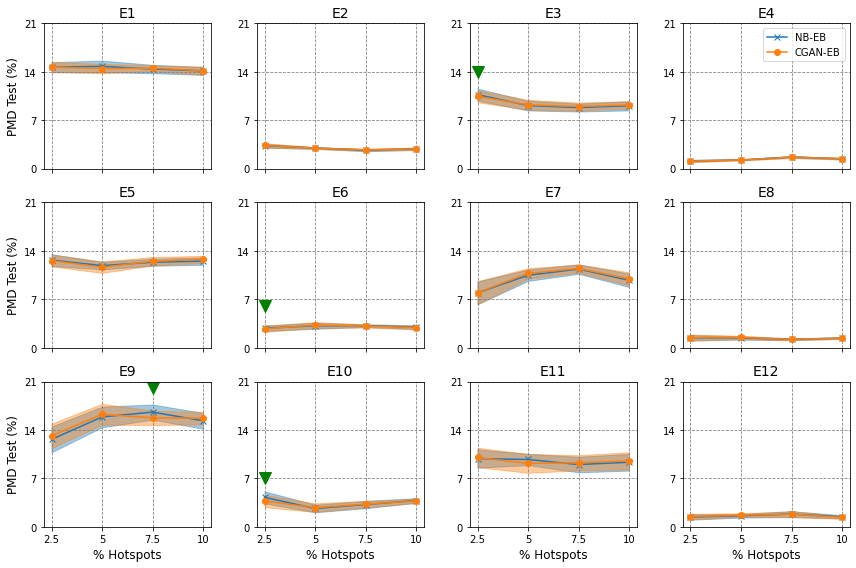

In [ ]:
## PMD plots

data = pd.read_excel('/content/Results.xlsx', sheet_name='Plots')
e_list = ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12']
data['HS'] = data['HS']/50

f,a = plt.subplots(3,4,figsize=(12,8),sharex=True)
a = a.ravel()

xy = {
      'E3':([0.05],[0.14]),
      'E6':([0.05],[0.06]),
      'E9':([0.15],[0.20]),
      'E10':([0.05],[0.07]),}


for scenario, idx, ax in zip(e_list,range(12),a):
    data_e = data[data['Ex']==scenario].copy()
    a[idx].plot(data_e['HS'], data_e['PMD NB-EB AVG'], label = 'NB-EB', marker='x')
    a[idx].plot(data_e['HS'], data_e['PMD CGAN-EB AVG'],  label = 'CGAN-EB', marker='o')
    a[idx].set_title(scenario, fontsize=14)

    if scenario in ['E9','E10','E11','E12']:
        a[idx].set_xlabel('% Hotspots', fontsize=12)
    if scenario in ['E1','E5','E9']:
        a[idx].set_ylabel('PMD Test (%)', fontsize=12)

    if scenario == 'E4':
        a[idx].legend(loc='upper right')
    a[idx].set_xticks([0.05,0.1,0.15,0.2])
    a[idx].set_xticklabels([2.5,5,7.5,10])

    a[idx].fill_between(data_e['HS'], data_e['PMD NB-EB AVG'] - data_e['PMD_nb_range'], data_e['PMD NB-EB AVG'] + data_e['PMD_nb_range'],
                 color='C0', alpha=0.4)
    a[idx].fill_between(data_e['HS'], data_e['PMD CGAN-EB AVG'] - data_e['PMD_gan_range'], data_e['PMD CGAN-EB AVG'] + data_e['PMD_gan_range'],
                 color='C1', alpha=0.4)


    a[idx].grid(color='gray', linestyle='dashed')
    plt.tight_layout()

    if scenario in ['E3', 'E6','E9','E10']:
        a[idx].plot(xy[scenario][0], xy[scenario][1] ,marker="v", c='green',markersize=12)

    a[idx].set_yticks([0,0.07,0.14,0.21])
    a[idx].set_yticklabels([0,7,14,21])

f.savefig('/content/PMD.pdf')


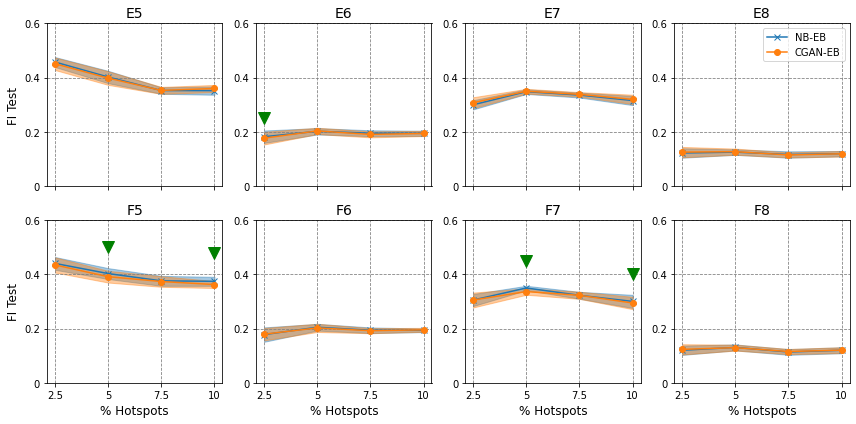

In [ ]:
## FI plots Non-linear

data = pd.read_excel('/content/Results.xlsx', sheet_name='Plots')
data['HS'] = data['HS']/10
e_list = ['E5','E6','E7','E8','F5','F6','F7','F8']

f,a = plt.subplots(2,4,figsize=(12,6), sharex=True)
a = a.ravel()

xy = {'E6':([0.25],[0.25]),
      
      'F5':([0.5,1],[0.50,0.48]),
      'F7':([0.5,1],[0.45,0.4]),
      }

for scenario, idx, ax in zip(e_list, range(12),a):
    data_e = data[data['Ex']==scenario].copy()
    a[idx].plot(data_e['HS'], data_e['TI NB-EB AVG'], label = 'NB-EB', marker='x')
    a[idx].plot(data_e['HS'], data_e['TI CGAN-EB AVG'],  label = 'CGAN-EB', marker='o')
    a[idx].set_title(scenario, fontsize=14)

    if scenario in ['F5','F6','F7','F8']:
        a[idx].set_xlabel('% Hotspots', fontsize=12)
    if scenario in ['E5','F5']:
        a[idx].set_ylabel('FI Test', fontsize=12)

    if scenario == 'E8':
        a[idx].legend(loc='upper right')
    a[idx].set_xticks([0.25,0.5,0.75,1])
    a[idx].set_xticklabels([2.5,5,7.5,10])

    a[idx].grid(color='gray', linestyle='dashed')

    a[idx].fill_between(data_e['HS'], data_e['TI NB-EB AVG'] - data_e['TI_nb_range'], data_e['TI NB-EB AVG'] + data_e['TI_nb_range'],
                 color='C0', alpha=0.4)
    a[idx].fill_between(data_e['HS'], data_e['TI CGAN-EB AVG'] - data_e['TI_gan_range'], data_e['TI CGAN-EB AVG'] + data_e['TI_gan_range'],
                 color='C1', alpha=0.4)
    



    if scenario in ['E6', 'F5', 'F7']:
        a[idx].plot(xy[scenario][0], xy[scenario][1],'s' ,marker="v", c='green',markersize=12)
    
    a[idx].set_yticks([0,0.2,0.4,0.6])
    a[idx].set_yticklabels([0,0.2,0.4,0.6])

    plt.tight_layout()
f.savefig('/content/FI_nonlinear.pdf') 


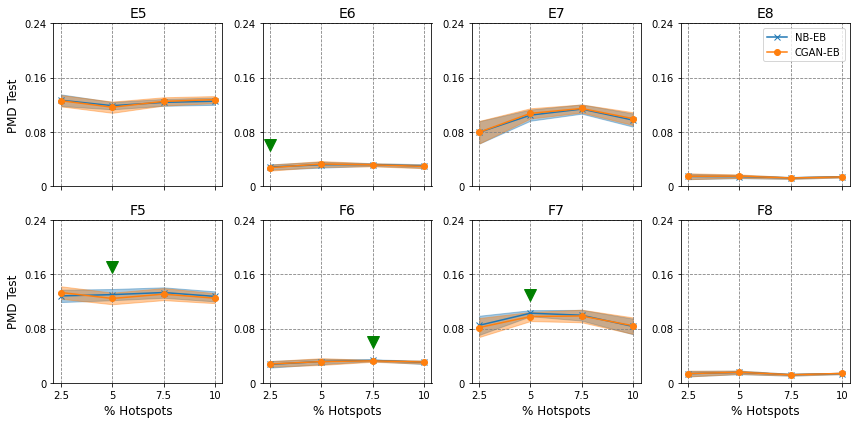

In [ ]:
## PMD plots Non-linear
from matplotlib.patches import Rectangle

data = pd.read_excel('/content/Results.xlsx', sheet_name='Plots')
e_list = ['E5','E6','E7','E8','F5','F6','F7','F8']

f,a = plt.subplots(2,4,figsize=(12,6), sharex=True)

data['HS'] = data['HS']/50


xy = {'E6':([0.05],[0.06]),
      'F5':([0.1],[0.17]),
      'F6':([0.15],[0.06]),
      'F7':([0.1],[0.13]),
      'F8':([0.15],[0.04]),
      }
      

a = a.ravel()

for scenario, idx, ax in zip(e_list, range(12),a):
    data_e = data[data['Ex']==scenario].copy()
    a[idx].plot(data_e['HS'], data_e['PMD NB-EB AVG'], label = 'NB-EB', marker='x')
    a[idx].plot(data_e['HS'], data_e['PMD CGAN-EB AVG'],  label = 'CGAN-EB', marker='o')
    a[idx].set_title(scenario, fontsize=14)

    if scenario in ['F5','F6','F7','F8']:
        a[idx].set_xlabel('% Hotspots', fontsize=12)
    if scenario in ['E5','F5','G5']:
        a[idx].set_ylabel('PMD Test', fontsize=12)

    if scenario == 'E8':
        a[idx].legend(loc='upper right')
    

    a[idx].set_xticks([0.05,0.1,0.15,0.2])
    a[idx].set_xticklabels([2.5,5,7.5,10])

    a[idx].fill_between(data_e['HS'], data_e['PMD NB-EB AVG'] - data_e['PMD_nb_range'], data_e['PMD NB-EB AVG'] + data_e['PMD_nb_range'],
                 color='C0', alpha=0.4)
    a[idx].fill_between(data_e['HS'], data_e['PMD CGAN-EB AVG'] - data_e['PMD_gan_range'], data_e['PMD CGAN-EB AVG'] + data_e['PMD_gan_range'],
                 color='C1', alpha=0.4)


    a[idx].grid(color='gray', linestyle='dashed')

    
    if scenario in ['E6','F5', 'F6','F7']:
        a[idx].plot(xy[scenario][0], xy[scenario][1],'s' ,marker="v", c='green',markersize=12)

    a[idx].set_yticks([0,0.08,0.16,0.24])
    a[idx].set_yticklabels([0,0.08,0.16,0.24])

    plt.tight_layout()
f.savefig('/content/PMD_nonlinear.pdf') 


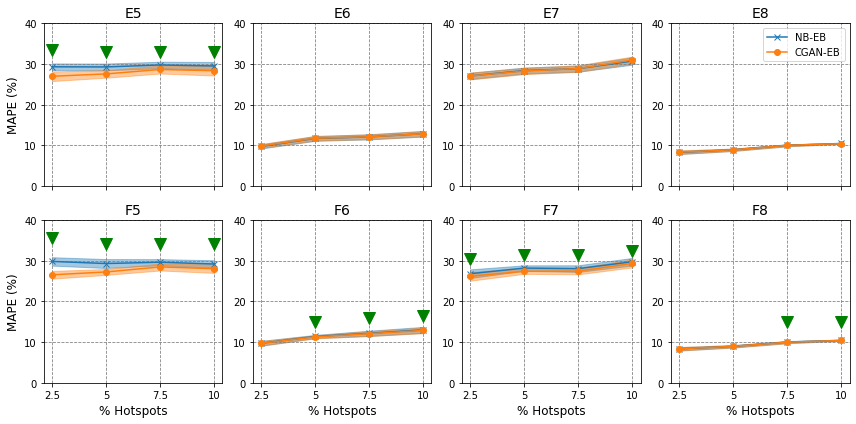

In [ ]:
## MAPE plots Non-linear vs Linear

data = pd.read_excel('/content/Results.xlsx', sheet_name='Plots')
e_list = ['E5','E6','E7','E8','F5','F6','F7','F8']

sf = 10
data['HS'] = data['HS']/sf


xy = {'E5':([2.5/sf,5/sf,7.5/sf,10/sf],[0.335,0.33,0.33,0.33]),
      'E8':([10/sf],[0.15]),
      'F5':([2.5/sf,5/sf,7.5/sf,10/sf],[0.355,0.34,0.34,0.34]),
      'F6':([5/sf,7.5/sf,10/sf],[0.15,0.16,0.165]),
      'F7':([2.5/sf,5/sf,7.5/sf,10/sf],[0.305,0.315,0.315,0.325]),
      'F8':([7.5/sf,10/sf],[0.15,0.15]),}
      

f,a = plt.subplots(2,4,figsize=(12,6), sharex=True)
a = a.ravel()

for scenario, idx, ax in zip(e_list, range(12),a):
    data_e = data[data['Ex']==scenario].copy()
    a[idx].plot(data_e['HS'], data_e['MAPE NB-EB AVG'], label = 'NB-EB', marker='x')
    a[idx].plot(data_e['HS'], data_e['MAPE CGAN-EB AVG'],  label = 'CGAN-EB', marker='o')
    a[idx].set_title(scenario, fontsize=14)

    if scenario in ['F5','F6','F7','F8']:
        a[idx].set_xlabel('% Hotspots', fontsize=12)
    if scenario in ['E5','F5']:
        a[idx].set_ylabel('MAPE (%)', fontsize=12)

    if scenario == 'E8':
        a[idx].legend(loc='upper right')
    

    a[idx].set_xticks([2.5/sf,5/sf,7.5/sf,10/sf])
    a[idx].set_xticklabels([2.5,5,7.5,10])

    a[idx].fill_between(data_e['HS'], data_e['MAPE NB-EB AVG'] - data_e['mape_nb_range'], data_e['MAPE NB-EB AVG'] + data_e['mape_nb_range'],
                 color='C0', alpha=0.4)
    a[idx].fill_between(data_e['HS'], data_e['MAPE CGAN-EB AVG'] - data_e['mape_gan_range'], data_e['MAPE CGAN-EB AVG'] + data_e['mape_gan_range'],
                 color='C1', alpha=0.4)


    a[idx].grid(color='gray', linestyle='dashed')

    if scenario in ['E5','F5','F6','F7','F8']:
        a[idx].plot(xy[scenario][0], xy[scenario][1],'s' ,marker="v", c='green',markersize=12)

    a[idx].set_yticks([0,0.1,0.2,0.3,0.4])
    a[idx].set_yticklabels([0,10,20,30,40])

    plt.tight_layout()
f.savefig('/content/mape_nonlinear.pdf') 
